<a target="_blank" href="https://colab.research.google.com/github/Thiago-Cerq/fastaiOnCampus/blob/main/lesson01_190117508_Thiago-Cerq_Thiago-Cerqueira-Borges.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Artigo 02: Identificador de Guerreiro

## Informações
* Autor: Thiago Cerqueira Borges
* Matrícula: 190117508
* GitHub: Thiago-Cerq

## Objetivo
> O objetivo deste artigo é treinar um modelo que distingue e categorize guerreiros, sendo eles, calaveiro, samurai ou viking.

# Passo 01: Baixar imagens dos tipos de guerreiros.
> Intalar as depêndecias
> Importar as funçoes que serão ultilizadas no artigo.

In [ ]:
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai
!pip install -Uqq fastdownload

from duckduckgo_search import ddg_images
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *


def search_images(term: str, max_images=300):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

> O primeiro teste será feito baixando apenas uma imagem de um guerreiro de cada tipo :

Searching for 'samurai'


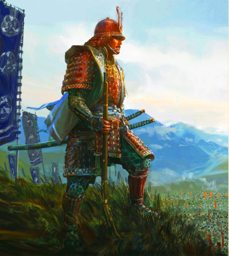

In [18]:
download_url(search_images('samurai', max_images=1)[0], 'samurai.jpg', show_progress=True)
Image.open('samurai.jpg').to_thumb(256,256)

Searching for 'cavaleiro'


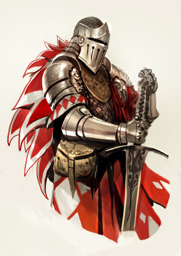

In [22]:
download_url(search_images('cavaleiro', max_images=1)[0], 'cavaleiro.jpg', show_progress=True)
Image.open('cavaleiro.jpg').to_thumb(256,256)

Searching for 'viking'


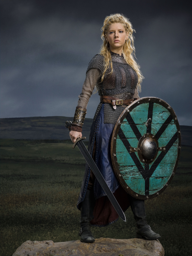

In [20]:
download_url(search_images('viking', max_images=1)[0], 'viking.jpg', show_progress=True)
Image.open('viking.jpg').to_thumb(256,256)

Searching for 'miyamoto musahi'


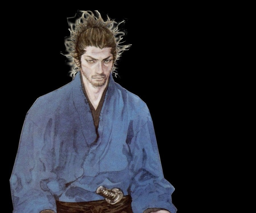

In [13]:
download_url(search_images('Miyamoto Musahi', max_images=1)[0], 'samurai.jpg', show_progress=True)
Image.open('samurai.jpg').to_thumb(256,256)

In [ ]:
Samurai: Miyamoto Musashi. Fonte: Vagabound.

Searching for 'Thorfinn'


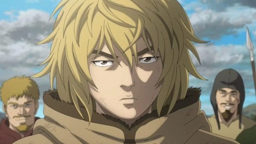

In [16]:
download_url(search_images('Thorfinn', max_images=1)[0], 'viking.jpg', show_progress=True)
Image.open('viking.jpg').to_thumb(256,256)

In [ ]:
Viking: Thorfinn Thorsson. Fonte: Vinland Saga.

Searching for 'Guts'


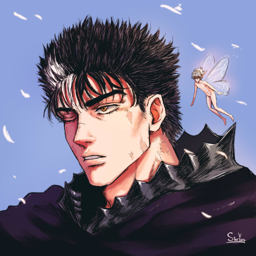

In [17]:
download_url(search_images('Guts', max_images=1)[0], 'cavaleiro.jpg', show_progress=True)
Image.open('cavaleiro.jpg').to_thumb(256,256)

In [ ]:
Cavaleiro: Guts. Fonte: Berserk.

> Verificamos se as imagens baixadas estão corretas. Elas serão usadas como inferência.

> Então podemos baixar um grande volume delas.

In [77]:
searches = 'samurai', 'viking', 'knight'
path = Path('warriors')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} image'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} picture'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} cosplay'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} art'))
    sleep(10)
    resize_images(path/o, max_size=400, dest= path/o)

Searching for 'samurai photo'
Searching for 'samurai image'
Searching for 'samurai picture'
Searching for 'samurai cosplay'
Searching for 'samurai art'


/home/thiago/2023.2/AM/fastaiOnCampus/.venv/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/thiago/2023.2/AM/fastaiOnCampus/.venv/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'viking photo'
Searching for 'viking image'
Searching for 'viking picture'
Searching for 'viking cosplay'
Searching for 'viking art'


/home/thiago/2023.2/AM/fastaiOnCampus/.venv/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'knight photo'
Searching for 'knight image'
Searching for 'knight picture'
Searching for 'knight cosplay'
Searching for 'knight art'


Foi utilizado o sleep para que não haja problemas no tráfego de informações.

> Essas imagens serão salvas em uma pasta cujo caminho está definido no path (warriors).

# Passo 2: Treinamento



Antes de iniciar o treinamento do modelo de fato é necessário garantir que não haja imagens com erro para evitar futuros problemas:

In [79]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Para treinar um modelo, é necessário utilizar os DataLoaders, que são objetos que incluem um conjunto de treinamento (as imagens usadas para criar o modelo) e um conjunto de validação (as imagens usadas para verificar a precisão do modelo, mas que não são usadas durante o treinamento). No fastai, podemos criar esses DataLoaders de forma simples utilizando um DataBlock e também visualizar exemplos de imagens a partir deles.
lo.

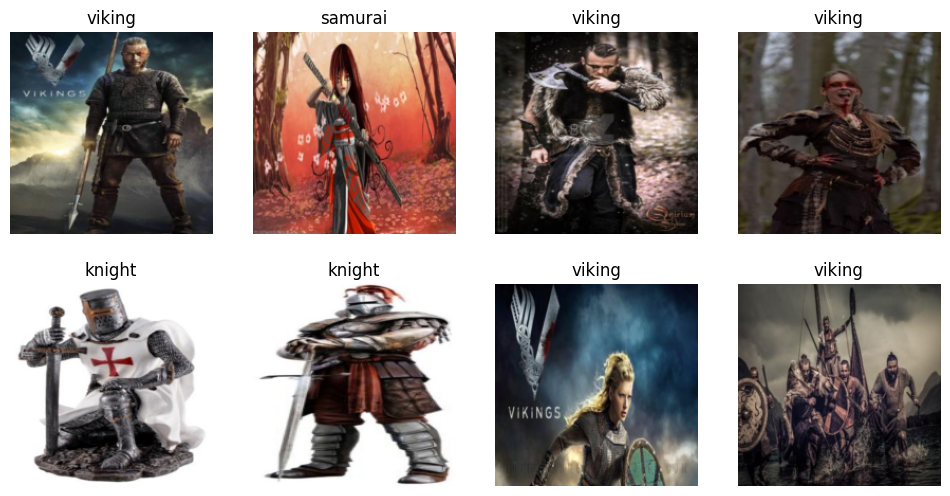

In [99]:
warriorsDB = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label, 
    item_tfms=[Resize(192, method='squish')] 
).dataloaders(path)

dls.show_batch(max_n=8)

Agora estamos prontos para treinar nosso modelo. O modelo de visão computacional mais rápido e amplamente utilizado é o resnet50. Você pode treiná-lo em poucos minutos, mesmo em uma CPU! (Em uma GPU, geralmente leva menos de 10 segundos...)

O fastai vem com um método útil fine_tune() que automaticamente usa as melhores práticas para ajustar um modelo pré-treinado, então usaremos isso.

As duas células forçam a execução do garbage collector e do cache e tambem faz com que o output do resultado dos modelos treinados sejam exibidos corretamente. Basicamente limpando resultados de execuções antigas e lixo de memoria.

In [100]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

79354

In [101]:
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

# Passo 3: Treinando

Após criar o Datablock, o modelo é treinado com a ajuda do objeto "Learner". Ele é configurado com três argumentos: o primeiro é um DataLoader (dls) que contém o conjunto de dados de treinamento do modelo; o segundo é a arquitetura ResNet18 que será usada como base para o modelo; e o terceiro é a métrica usada para avaliar a performance do modelo, que neste caso é a taxa de erro.

Para realizar o ajuste fino do modelo, é utilizado o método "fine_tune()". Esse método realiza um treinamento adicional do modelo usando os pesos pré-treinados da ResNet18 como ponto de partida.

In [102]:
learn = vision_learner(warriorsDB, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.293826,0.107068,0.040404,00:17
1,0.150346,0.080791,0.020202,00:18
2,0.082211,0.072519,0.028283,00:27
3,0.044904,0.069469,0.020202,00:25
4,0.025871,0.056172,0.020202,00:25
5,0.016002,0.058989,0.020202,00:23


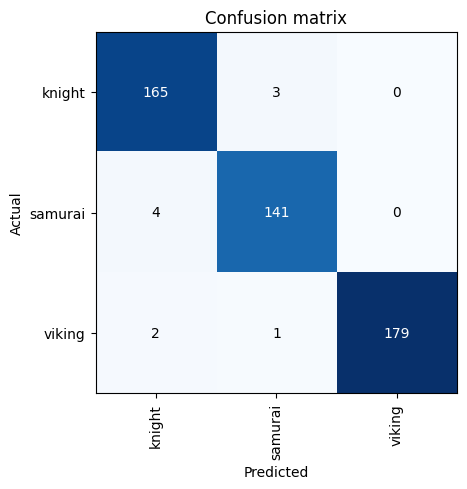

In [103]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [3]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

NameError: name '_C' is not defined

# Testando o modelo

Com o modelo treinado, ao executar a última tela, receberá um prompt que informará o tipo de aeronave da pessoa na foto, a probabilidade de ser o tipo de aeronave previsto e a imagem inserida.

In [14]:
translator = {
    "civil airplane": "Avião Civil",
    "military airplane": "Avião Militar",
}

É um Avião Militar.
Probabilidade de ser do tipo Avião Militar: 96.90%


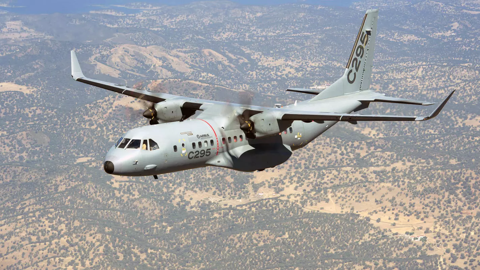

In [28]:
prediction_photo='miliAirplane.jpg'

airplane_type,_,probs = learn.predict(PILImage.create(prediction_photo))
print(f"É um {translator[airplane_type]}.")
print(f"Probabilidade de ser do tipo {translator[airplane_type]}: {probs.sort()[0][-1]*100:.2f}%")
Image.open(prediction_photo).to_thumb(480,480)

# Conclusão
A utilização do fastai simplifica significativamente o processo de treinamento de modelos para reconhecimento de imagens. Minha principal dificuldade pessoal estava relacionada à linguagem utilizada, uma vez que não possuía conhecimento prévio nessa área. No entanto, aproveitei a primeira semana, mesmo antes de receber as instruções completas sobre como a disciplina funcionaria, para me concentrar na compreensão do Python. Depois de superar esse desafio inicial, fiquei muito satisfeito com o material disponibilizado e achei que ele proporcionou um excelente ponto de partida para minha jornada de aprendizado em machine learning. 
Contudo a IA tem um pouco de dificuldade de identificar aviões comerciais com propulsão a jato, acredito que o problema deriva se das imagens baixadas, é comum aparecer imagens apenas da turbina dificultando a diferenciação.


# Referências

> Jeremy Howard and Sylvain Gugge. FastBook. Disponível em https://github.com/fastai/fastbook. 
Acessado e 10 de Setembro de 2023.023

> Repositorio da Disciplina Disponível em https://github.com/fabraz/fastaiOnCampus. Acessado em 10 de Setembro de 2023.